# Calculo das variáveis aleatórias
Temos que no código abaixo possui a implementação das seguintes distribuições: <br>
- Distribuição normal;
- Distribuição log-normal;
- Gumbel para máximos e Gumbel para mínimos <br>

No código abaixo, temos uma estrutura de _data members_, na qual é possível calcular os momentos da distribuição (média, variância, desvio-padrão, coeficiente de variação, skewness e kurtosis) dado os parâmetros. <br>
Além disso, há uma estrutura de _member functions_ que calcula as funções $PDF$, $CDF$ e $CDF^{-1}$ e também calcula os parâmetros dados os momentos.


In [1]:
from scipy import stats as st 
import numpy as np
import matplotlib.pyplot as plt

# Data members
class variavel_aleatoria:
    # Função para identificar qual é a distribuição, o nome da variável e o simbolo da distribuição
    def __init__(self, distribuicao: str, nome: str = "", simbolo: str =""):
        # Identificação
        self.nome = nome
        self.simbolo = simbolo
        self.distribuicao = distribuicao  

        # Lista de argumentos
        self.parametros = []
        self.objeto = None

        # Momentos da variável
        self.media = np.nan 
        self.variancia = np.nan
        self.desvio = np.nan
        self.cv = np.nan # Coeficiente de variação
        self.skewness = np.nan
        self.kurtosis = np.nan

        # Distribuições implementadas
        self.distribuicoes = {
            'normal' : st.norm,
            'lognormal' : st.lognorm,
            'gumbel_max': st.gumbel_r,
            'gumbel_min': st.gumbel_l,
            'uniforme': st.uniform
        }

        # Aqui as distribuições contempladas são atribuidas ao componente objeto
        self.objeto = self.distribuicoes[self.distribuicao]

        # Aqui os parâmetros de cada distribuição são definidos e os momentos calculados a partir dos parâmetros
    def conjunto_parametros (self, *params):
        self.parametros = list(params)
        self.calculo_momentos()
    
        # Aqui os momentos são calculados a partir dos parametros
    def calculo_momentos(self):
        m, v, sk, k = self.objeto.stats(*self.parametros, moments = 'mvsk')

        # Armazenamento dos momentos nas variáveis
        self.media = float(m)
        self.variancia = float(v)
        self.desvio = np.sqrt(self.variancia)
        self.skewness = float(sk)
        self.kurtosis = float(k)

        if self.distribuicao == 'uniforme':
            loc = self.parametros[0]
            scale = self.parametros[1]

            a = loc
            b = loc + scale

            self.media = (a + b) / 2.0
            self.variancia = (scale ** 2) / 12
            self.desvio = np.sqrt(self.variancia) 
            self.skewness = 0.0
            self.kurtosis = 1.8

        if self.media != 0:
            self.cv = self.desvio / self.media
        else:
            self.cv = np.nan

    # Aqui calcula-se os parametros de cada distribuição dado os momentos (média e desvio padrão)
    def calculo_parametros (self, media_dada: float, desvio_dado: float):
        mu = media_dada
        sigma = desvio_dado

        if self.distribuicao =='normal':
            self.conjunto_parametros(mu, sigma)
        
        elif self.distribuicao == 'lognormal':
            zeta = np.sqrt(np.log(1.0 + (sigma / mu) ** 2))
            lam = np.log(mu) - (0.5 * (zeta ** 2))
            scale = np.exp(lam)
            self.conjunto_parametros(zeta, 0.0, scale)
        
        elif self.distribuicao == 'uniforme':
            scale = desvio_dado * np.sqrt(12)
            loc = media_dada - (scale / 2.0)
            self.calculo_parametros(loc, scale)

        elif self.distribuicao in ['gumbel_max', 'gumbel_min']:
            mu = media_dada
            sigma = desvio_dado
            gamma = 0.5772156649 #Constante de Euler
            beta = (sigma * np.sqrt(6)) / np.pi 

            if self.distribuicao == 'gumbel_max':
                mu_calc = mu - (gamma * beta)
            else:
                mu_calc = mu + (gamma * beta)
            self.conjunto_parametros(mu_calc, beta)
    
    # Agora vamos construir as funções fundamentais (PDF, CDF, Inversa)
    def PDF (self, x: float) -> float:
        if self.objeto:
            return self.objeto.pdf(x, *self.parametros)
        return np.nan
    
    def CDF (self, x: float) -> float:
        if self.objeto:
            return self.objeto.cdf(x, *self.parametros)
        return np.nan
    
    def InversaCDF (self, p: float) -> float:
        if self.objeto:
            return self.objeto.ppf(p, *self.parametros)
        return np.nan

# Plot das distribuições
Para a tensão média p' temos a seguinte distribuição


In [10]:
#Teste da estrutura
effective_mean_stress = variavel_aleatoria(distribuicao = 'normal', nome='VA lognormal', simbolo='X_LN')
media_dada = 527.822
sigma_dado = 381.481
effective_mean_stress.conjunto_parametros(media_dada, sigma_dado)

# Teste do conjunto de parametros e momentos para uma distribuição normal
print('Verificação da distribuição normal: Calculo dos momentos dados os parâmetros')
print(f"X: {effective_mean_stress.nome}")
print(f"Parâmetros: {effective_mean_stress.parametros}")
print(f"Média calculada: {effective_mean_stress.media}")
print(f"Desvio padrão: {effective_mean_stress.desvio}")
print(f"Coeficiente de variação: {effective_mean_stress.cv}")
print(f"Skewness: {effective_mean_stress.skewness}")
print(f"Kurtosis: {effective_mean_stress.kurtosis}")

Verificação da distribuição normal: Calculo dos momentos dados os parâmetros
X: VA lognormal
Parâmetros: [527.822, 381.481]
Média calculada: 527.822
Desvio padrão: 381.481
Coeficiente de variação: 0.7227455467941843
Skewness: 0.0
Kurtosis: 0.0


Uma vez calculados os parâmetros, agora vamos vamos plotar os resultados $x_{aprox} = CDF^{-1}(x,CDF(X,x))$ para um intervalo $\mu - 3\sigma \leq x \leq \mu + 3\sigma$ e também vamos plotar a função $PDF$ para a tensão efetia média.

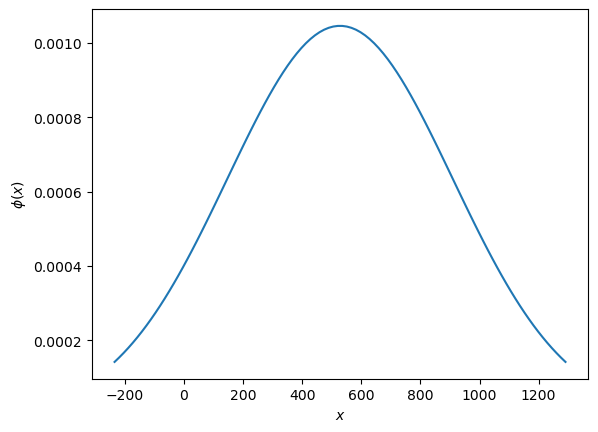

In [11]:
import matplotlib.pyplot as plt


x_min = media_dada - (2 * sigma_dado)
x_max = media_dada + (2 * sigma_dado)
x_real = np.linspace(x_min, x_max, 100)

'''
x_min = 0.001
x_max = 0.999
x_min_plot = effective_mean_stress.InversaCDF(x_min)
x_max_plot = effective_mean_stress.InversaCDF(x_max)
x_real = np.linspace(x_min_plot, x_max_plot, 100)
'''

x_aproximado = []
pdf = []
for x in x_real:
    p = effective_mean_stress.CDF(x)
    pdf_calc = effective_mean_stress.PDF(x)
    x_calc = effective_mean_stress.InversaCDF(p)
    x_aproximado.append(x_calc)
    pdf.append(pdf_calc)

# Plotar função PDF
plt.plot(x_real, pdf)
plt.xlabel('$x$')
plt.ylabel('$\\phi(x)$')
plt.show()

Agora vamos plotar a distribuição relativa ao indice de vazios


In [12]:
#Teste da estrutura
X_lognormal = variavel_aleatoria(distribuicao = 'lognormal', nome='VA lognormal', simbolo='X_LN')
zeta_dado = 0.2
lamb_dado = 5
X_lognormal.conjunto_parametros(zeta_dado, 0, float(np.exp(lamb_dado)))

# Teste do conjunto de parametros e momentos para uma distribuição normal
print('Verificação da distribuição lognormal: Calculo dos momentos dados os parâmetros')
print(f"X: {X_lognormal.nome}")
print(f"Parâmetros: {lamb_dado, zeta_dado}")
print(f"Média calculada: {X_lognormal.media}")
print(f"Desvio padrão: {X_lognormal.desvio}")
print(f"Coeficiente de variação: {X_lognormal.cv}")
print(f"Skewness: {X_lognormal.skewness}")
print(f"Kurtosis: {X_lognormal.kurtosis}")

Verificação da distribuição lognormal: Calculo dos momentos dados os parâmetros
X: VA lognormal
Parâmetros: (5, 0.2)
Média calculada: 151.41130379405274
Desvio padrão: 30.587622095939498
Coeficiente de variação: 0.20201676710706024
Skewness: 0.6142947619866632
Kurtosis: 0.6783657771754372


Uma vez calculados os parâmetros, agora vamos vamos plotar os resultados $x_{aprox} = CDF^{-1}(x,CDF(X,x))$ e também vamos plotar a função $PDF$.

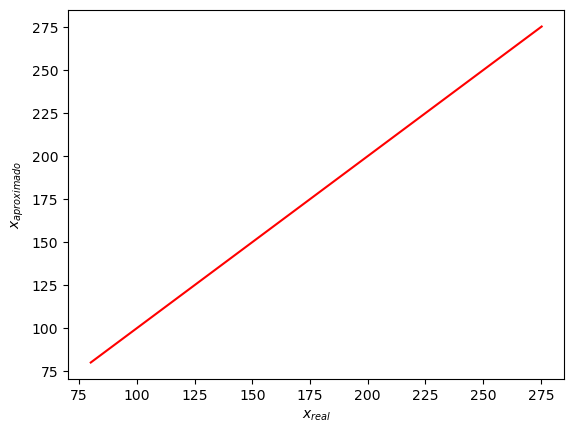

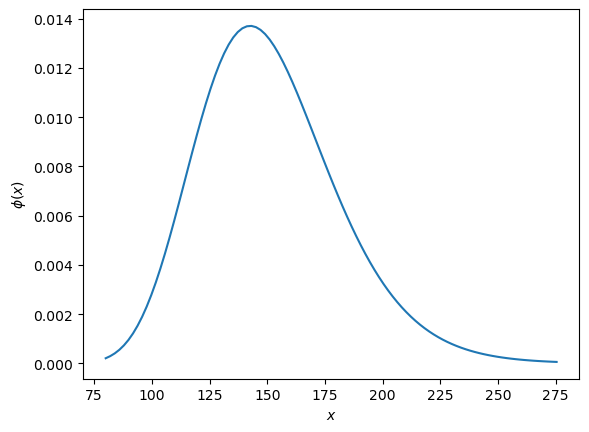

In [13]:
import matplotlib.pyplot as plt

x_min = 0.001
x_max = 0.999
x_min_plot = X_lognormal.InversaCDF(x_min)
x_max_plot = X_lognormal.InversaCDF(x_max)
x_real = np.linspace(x_min_plot, x_max_plot, 100)

x_aproximado = []
pdf = []
for x in x_real:
    p = X_lognormal.CDF(x)
    pdf_calc = X_lognormal.PDF(x)
    x_calc = X_lognormal.InversaCDF(p)
    x_aproximado.append(x_calc)
    pdf.append(pdf_calc)

# Gráfico do valor aproximado x valor real
plt.plot(x_real, x_aproximado, 'r')
plt.xlabel('$x_{real}$')
plt.ylabel('$x_{aproximado}$')
plt.show()

# Plotar função PDF
plt.plot(x_real, pdf)
plt.xlabel('$x$')
plt.ylabel('$\\phi(x)$')
plt.show()

# Algoritmo de mapeamento
Temos que o código abaixo faz o caclulo da matriz de correlação $R_z$ utilizando a distribuição de Nataf e calcula os Jacobianos $J_{yz}$ e $J_{zy}$ da tranformação $(Z -> Y)$ tanto utilizando a decomposição de Cholesky quanto a decomposição ortogonal.

In [2]:
import numpy as np
from UQpy.transformations import Nataf
from UQpy.distributions import Normal as uqpynormal
from UQpy.distributions import Lognormal as uqpylognormal
from UQpy.distributions import Uniform as uqpyuniform
from UQpy.distributions.collection import GeneralizedExtreme as uqpygev  

# Função de mapeamento para o uso do UQpy que retorna os parametros de cada distribuição
def mapeamento_uqpy(va_cust):
    tipo = va_cust.distribuicao.lower()
    parametros = va_cust.parametros

    if tipo == 'normal':
        return uqpynormal(loc=parametros[0], scale=parametros[1])

    elif tipo == 'lognormal':
        return uqpylognormal(s=parametros[0], loc=parametros[1], scale=parametros[2])
    
    elif tipo in ['gumbel_max', 'gumbel_min']:
        shape_c = 0.0
        loc = parametros[0]   
        scale = parametros[1] 
        return uqpygev(c=shape_c, loc=loc, scale=scale)
    
    elif tipo == 'uniforme':
        loc = parametros[0]
        scale = parametros[1]
        return uqpyuniform(loc=loc, scale=scale)
    
    else:
        raise ValueError(f"Distribuição '{tipo}' não mapeada")
        
# Data members
class vetores_variavel_aleatoria:
    matriz_observações: np.ndarray # Cada linha é uma variável aleatória X_i e cada coluna uma observação
    vetor_va_cust: list
    matriz_correlacao_x: np.ndarray # Matriz de correlação
    matriz_correlacao_z: np.ndarray = None

    # Função de recebimento do vetor
    def __init__(self, matriz_observacoes: np.ndarray, vetor_va_cust: list):
        
        self.matriz_observações = matriz_observacoes
        self.vetor_va_cust = vetor_va_cust
        self.calc_matriz_correlacao()

    # Determinação da dimensão do vetor de variáveis aleatórias
    def dimensao (self) -> tuple:
        return np.shape(self.vetor_va_cust)
    
    # Calculo da matriz de correlação Rx
    def calc_matriz_correlacao(self):
        self.matriz_correlacao_x = np.corrcoef(self.matriz_observações)
        return self.matriz_correlacao_x

    # Calculo da matriz de correlação no espaço normal padrão (Rz) 
    def matriz_correlacao_nataf(self) -> np.ndarray:
        distribuicoes_uqpy = [mapeamento_uqpy(va) for va in self.vetor_va_cust]
        
        nataf_obj = Nataf(distributions=distribuicoes_uqpy, corr_x=self.matriz_correlacao_x)
        
        Rz = nataf_obj.corr_z # Matriz de corelação zij
        self.matriz_correlacao_z = Rz
        
        return Rz
    
    # Matriz de eliminação da correlação via decomposição de Cholesky e calculo dos Jacobianos Z -> Y
    def decomposicao_cholesky(self) -> np.ndarray:
        B = np.linalg.cholesky(self.matriz_correlacao_z)
        
        L = np.linalg.inv(B.T)
        Jyz = np.linalg.inv(L) # Jacobiano Jyz
        Jzy = L # Jacobiano Jzy

        return Jyz, Jzy
    
    # Matriz de eliminação da correlação via decomposição de decomposição ortogonal e calculo dos Jacobianos Z -> Y
    def descorrelacao_autovetores(self) -> np.ndarray:
        Rz = self.matriz_correlacao_z

        # W é o vetor de autovalores
        # A_barra é a matriz onde cada coluna é um autovetor de Rz 
        W, A_barra = np.linalg.eigh(Rz) 

        # Construção da diagonal da matriz inversa dos auto-valores
        Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(W))

        # Matriz de descorrelação A
        A = A_barra @ Lambda_inv_sqrt

        # Jacobiano Jyz
        Jyz = A.T

        # Jacobiano Jzy
        Jzy = np.linalg.inv(A.T)

        return Jyz, Jzy

# Tarefa T4
Para resolução da tarefa 4 vamos resolver o Exemplo 4 apresentado no livro. Para isso implementamos o algoritmo FORM completo, o qual se reduz ao algoritmo FOSM uma vez que todas as variáveis possuem distribuição normal. Para essa resolução, o ponto $y_{k+1}$ foi calculado de acordo com a Equação 3.33 apresentada no livro, sem a implementação do algortimo HLRF. 
$$
y_{k+1}=-\alpha_k[\Beta_{k} + \frac{g(y_k)}{||\nabla g(y_k)||}]
$$
Como critério de parada, utilizou-se:
$$
1 - |\frac{\nabla g(y_{k+1})y_{k+1}}{||\nabla g(y_{k+1})|| ||y_{k+1}||}| < \epsilon \\
$$
$$
|g(y_{k+1})| < \delta
$$

In [15]:
import numpy as np
import scipy as sc
import sympy as sp
from sympy.utilities.lambdify import lambdify
from typing import Callable, List, Tuple

class Ponto_projeto:
    def __init__(self, vx_obj, g_fun_numerica_x, calculo_g_y, g_sym_fun, vetor_simbolico, x_inicial, max_iter=100):

        # Inicialização das variáveis
        self.vx_obj = vx_obj 
        self.g_fun_x_num = g_fun_numerica_x
        self.g_y_num = calculo_g_y
        self.grad_g_x_fun = self.calcular_gradiente_simbolico_x(g_sym_fun, vetor_simbolico)
        self.x_estrela_atual = x_inicial
        self.max_iter = max_iter
        self.historico = []

    # Atualização das matrizes de média e desvio padrão equivalente
    def normal_equivalente_no_ponto (self, vetor_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        mu_neq_lista = []
        sigma_neq_lista = []

        for i, va in enumerate(self.vx_obj.vetor_va_cust):
            x_i = vetor_x[i]

            cdf_xi = va.CDF(x_i)
            pdf_xi = va.PDF(x_i)

            z_i = sc.stats.norm.ppf(cdf_xi)
            phi_zi = sc.stats.norm.pdf(z_i)

            sigma_neq_i = phi_zi / pdf_xi
            mu_neq_i = x_i - (z_i * sigma_neq_i)

            mu_neq_lista.append(mu_neq_i)
            sigma_neq_lista.append(sigma_neq_i)

        return np.array(mu_neq_lista), np.diag(sigma_neq_lista)
    
    # Calculo do gradiente numérico da função g(x) a partir da função simbólica fornecida paara g(x)
    def calcular_gradiente_simbolico_x(self, g_sym:sp.Expr, vetor_simbolico: List[sp.Symbol]) -> Callable:
        
        grad_g_sym = [sp.diff(g_sym, x_i) for x_i in vetor_simbolico]

        grad_g_numeric = lambdify(vetor_simbolico, grad_g_sym, 'numpy')
        
        def grad_g_x_numerico(x_vals: np.ndarray) -> np.ndarray:
            return np.array(grad_g_numeric(*x_vals))
        
        return grad_g_x_numerico
     
    # Estrutura principal de calculo e iteração em busca do ponto de projeto
    def execution (self,):

        historico = [] # Vetor que armazena o histórico de iterações

        for k in range(self.max_iter):
            
            # Ponto de projeto x* para a iteração k
            x_k = self.x_estrela_atual 

            # Atualização das matrizes de média e desvio padrão equivalentes para o ponto x_k
            # Calculo dos Jacobianos da transformação X -> Z
            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            # Trandformação do ponto xk -> yk
            y_k = J_yx @ (x_k - mu_neq)

            # Calculo do índice de confiabilidade para o ponto yk
            beta_k = np.linalg.norm(y_k)
            
            # Avaliação das funções g(x) em x_k e g(y) em y_k
            g_x = self.g_fun_x_num(x_k)
            g_y = self.g_y_num(y_k)

            if k == 0:
                g_y_zero = g_y

            # Calculo do gradiente de g(x) no espaço de projeto X em x_k
            grad_g_x = self.grad_g_x_fun(x_k)

            # Calculo do gradiente de g(y) em y_k a partir da transformação X -> Y
            grad_g_y = (J_xy.T) @ grad_g_x

            # Calculo dos coeficientes de sensibilidade
            alpha = grad_g_y / np.linalg.norm(grad_g_y)

            historico.append([
                k, 
                y_k, 
                beta_k, 
                g_x, 
                grad_g_y, 
                np.linalg.norm(grad_g_y)
            ])  

            # Calculo do ponto de projeto y_k+1
            #y_k_mais_1 = (((1 / np.linalg.norm(grad_g_y)) ** 2) * (((grad_g_y.T) @ y_k) - g_y)) * grad_g_y # Algoritmo HLRF
            y_k_mais_1 = - alpha * (beta_k + ((g_y) / np.linalg.norm(grad_g_y)))
            
            # Calculo do ponto x_k+1 a partir da tranformação Y -> X
            x_k_mais_1 = (J_xy @ y_k_mais_1) + mu_neq

            # Verificação da convergência do ponto y_k+1
            ep = 1e-3    
            g_x_mais_1 = self.g_fun_x_num(x_k_mais_1)
            grad_x_mais_1 = self.grad_g_x_fun(x_k_mais_1)
            g_y_mais_1 = self.g_y_num(y_k_mais_1)
            grad_y_mais_1 = (J_xy.T) @ grad_x_mais_1
            verificador = 1 - (abs((grad_y_mais_1.T @ y_k_mais_1) / ((np.linalg.norm(grad_y_mais_1)) * (np.linalg.norm(y_k_mais_1)))))
            
            if verificador < ep:
                if abs(np.linalg.norm(g_y_mais_1)) < (ep * g_y_zero):

                    historico.append([
                        k+1, 
                        y_k_mais_1, 
                        np.linalg.norm(y_k_mais_1), 
                        g_x_mais_1, 
                        grad_y_mais_1, 
                        np.linalg.norm(grad_y_mais_1)
                    ])  
                    break
                else:
                    self.x_estrela_atual = x_k_mais_1 
            else:
                self.x_estrela_atual = x_k_mais_1

                if k == self.max_iter - 1:
                    print(f"Não convergiu em {self.max_iter} iterações")
    
        return historico

# Busca do pronto de projeto

No código abaixo, a busca pelo ponto $y_{k+1}$ é realizada utilizando a implementação do algoritmo *HLRF*

In [3]:
import numpy as np
import scipy as sc
import sympy as sp
from sympy.utilities.lambdify import lambdify
from typing import Callable, List, Tuple

class Ponto_projeto_HRLF:
    def __init__(self, vx_obj, g_fun_numerica_x, vetor_simbolico_y, g_y_simbolico, g_sym_fun, vetor_simbolico, x_inicial, max_iter=100):

        # Inicialização das variáveis
        self.vx_obj = vx_obj 
        self.g_fun_x_num = g_fun_numerica_x
        self.vetor_simbolico_y = vetor_simbolico_y
        self.g_y_simbolico = g_y_simbolico
        self.grad_g_x_fun = self.calcular_gradiente_simbolico_x(g_sym_fun, vetor_simbolico)
        self.x_estrela_atual = x_inicial
        self.max_iter = max_iter
        self.historico = []

    # Atualização das matrizes de média e desvio padrão equivalente
    def normal_equivalente_no_ponto (self, vetor_x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        mu_neq_lista = []
        sigma_neq_lista = []

        for i, va in enumerate(self.vx_obj.vetor_va_cust):
            x_i = vetor_x[i]

            cdf_xi = va.CDF(x_i)
            pdf_xi = va.PDF(x_i)

            z_i = sc.stats.norm.ppf(cdf_xi)
            phi_zi = sc.stats.norm.pdf(z_i)

            sigma_neq_i = phi_zi / pdf_xi
            mu_neq_i = x_i - (z_i * sigma_neq_i)

            mu_neq_lista.append(mu_neq_i)
            sigma_neq_lista.append(sigma_neq_i)

        return np.array(mu_neq_lista), np.diag(sigma_neq_lista)
    
    # Calculo do gradiente numérico da função g(x) a partir da função simbólica fornecida paara g(x)
    def calcular_gradiente_simbolico_x(self, g_sym:sp.Expr, vetor_simbolico: List[sp.Symbol]) -> Callable:
        
        grad_g_sym = [sp.diff(g_sym, x_i) for x_i in vetor_simbolico]

        grad_g_numeric = lambdify(vetor_simbolico, grad_g_sym, 'numpy')
        
        def grad_g_x_numerico(x_vals: np.ndarray) -> np.ndarray:
            return np.array(grad_g_numeric(*x_vals))
        
        return grad_g_x_numerico
     
    # Estrutura principal de calculo e iteração em busca do ponto de projeto
    def execution (self,):

        historico = [] # Vetor que armazena o histórico de iterações

        for k in range(self.max_iter):
            
            # Ponto de projeto x* para a iteração k
            x_k = self.x_estrela_atual 

            # Atualização das matrizes de média e desvio padrão equivalentes para o ponto x_k
            # Calculo dos Jacobianos da transformação X -> Z
            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            vetor_simbolico_y = self.vetor_simbolico_y
            vetor_simbolico_x_calc = (J_xy @ vetor_simbolico_y) + mu_neq
            g_y_simbolico = self.g_y_simbolico(vetor_simbolico_x_calc)
            g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')
            
            def calculo_g_y(vetor_y):
                return g_y_numerico(*vetor_y)
            
            # Trandformação do ponto xk -> yk
            y_k = J_yx @ (x_k - mu_neq)

            # Calculo do índice de confiabilidade para o ponto yk
            beta_k = np.linalg.norm(y_k)
            
            # Avaliação das funções g(x) em x_k e g(y) em y_k
            g_x = self.g_fun_x_num(x_k)
            g_y = calculo_g_y(y_k)

            if k == 0:
                g_y_zero = g_y

            # Calculo do gradiente de g(x) no espaço de projeto X em x_k
            grad_g_x = self.grad_g_x_fun(x_k)

            # Calculo do gradiente de g(y) em y_k a partir da transformação X -> Y
            grad_g_y = (J_xy.T) @ grad_g_x

            # Calculo dos coeficientes de sensibilidade
            alpha = grad_g_y / np.linalg.norm(grad_g_y)

            historico.append([
                k, 
                y_k, 
                beta_k, 
                g_x, 
                grad_g_y, 
                np.linalg.norm(grad_g_y),
                g_y,
                x_k
            ])  

            # Calculo do ponto de projeto y_k+1
            y_k_mais_1 = (((1 / np.linalg.norm(grad_g_y)) ** 2) * (((grad_g_y.T) @ y_k) - g_y)) * grad_g_y # Algoritmo HLRF
            #y_k_mais_1 = - alpha * (beta_k + ((g_y) / np.linalg.norm(grad_g_y)))
            
            # Calculo do ponto x_k+1 a partir da tranformação Y -> X
            x_k_mais_1 = (J_xy @ y_k_mais_1) + mu_neq

            mu_neq, D_neq = self.normal_equivalente_no_ponto(x_k_mais_1)
            D_neq_inv = np.linalg.inv(D_neq)
            J_yz = self.vx_obj.decomposicao_cholesky()[0]
            J_zy = self.vx_obj.decomposicao_cholesky()[1]

            # Atualização dos Jacobianos da transformação X -> Y
            J_xy = D_neq @ J_zy
            J_yx = J_yz @ D_neq_inv

            vetor_simbolico_y = self.vetor_simbolico_y
            vetor_simbolico_x_calc = (J_xy @ vetor_simbolico_y) + mu_neq
            g_y_simbolico = self.g_y_simbolico(vetor_simbolico_x_calc)
            g_y_numerico = lambdify(vetor_simbolico_y, g_y_simbolico, 'numpy')
            def calculo_g_y(vetor_y):
                return g_y_numerico(*vetor_y)

            # Verificação da convergência do ponto y_k+1
            ep = 1e-3    
            g_x_mais_1 = self.g_fun_x_num(x_k_mais_1)
            grad_x_mais_1 = self.grad_g_x_fun(x_k_mais_1)

            g_y_mais_1 = calculo_g_y(y_k_mais_1)
            grad_y_mais_1 = (J_xy.T) @ grad_x_mais_1

            alpha_mais_1 = grad_y_mais_1 / np.linalg.norm(grad_y_mais_1)

            verificador = 1 - (abs((grad_y_mais_1.T @ y_k_mais_1) / ((np.linalg.norm(grad_y_mais_1)) * (np.linalg.norm(y_k_mais_1)))))
            
            if verificador < ep:
                if abs(g_y_mais_1) < abs (ep * g_y_zero):

                    historico.append([
                        k+1, 
                        y_k_mais_1, 
                        np.linalg.norm(y_k_mais_1), 
                        g_x_mais_1, 
                        grad_y_mais_1, 
                        np.linalg.norm(grad_y_mais_1),
                        g_y_mais_1,
                        x_k_mais_1
                    ])  

                    break
                else:
                    self.x_estrela_atual = x_k_mais_1 
            else:
                self.x_estrela_atual = x_k_mais_1

                if k == self.max_iter - 1:
                    print(f"Não convergiu em {self.max_iter} iterações")
    
        return historico

Tentativa do FORM com HRLF

# Tentativa com todos os componentes para a primeira equação

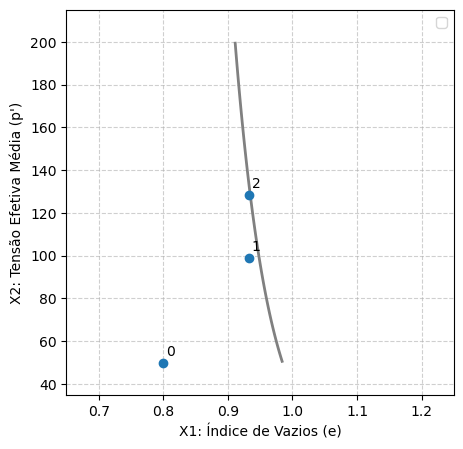

,k,y_k,B,g(x),grad_g(y),||grad_g(y)||,g(y),x_k
0,0,"[-0.461, -1.689, 0.102]",1.753,0.185,"[-0.2, -0.085, 0.0]",0.217,0.185,"[0.8, 50.0, 0.97]"
1,1,"[-0.087, -0.574, -0.001]",0.581,0.016,"[-0.2, -0.085, 0.0]",0.217,0.016,"[0.933, 99.003, 0.95]"
2,2,"[-0.213, -0.09, 0.0]",0.231,0.002,"[-0.2, -0.085, 0.0]",0.217,0.000,"[0.933, 128.4, 0.95]"


In [15]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Equação do estado limite g(X)
e,p,n = sp.symbols('e p n')
vetor_simbolico_x = [e, p, n]
g_sym_function = -(e - (1.242 - (0.053 * sp.log(p)))) - 0.05

def g_fun_numerica_g1(x: np.ndarray) -> float:
    return -(x[0] - (1.242 - (0.053 * np.log(x[1])))) - 0.05

# Transformação X -> Y da equação de estado-limite g(X)
Y1,Y2, Y3 = sp.symbols('Y1 Y2 Y3')
vetor_simbolico_y = [Y1, Y2, Y3]
def g_y_simbolico_fun (vetor_x_simbolico):
    return  -(vetor_x_simbolico[0] - (1.242 - (0.053 * sp.log(vetor_x_simbolico[1])))) - 0.05       

# Descrição das variáveis aleatórias 
e = variavel_aleatoria(distribuicao='normal', nome='Indices_vazio', simbolo='e')
e.conjunto_parametros(0.98, 0.2) 

p = variavel_aleatoria(distribuicao='lognormal', nome='Mean_effective_stess', simbolo='p')
p.calculo_parametros(167.88, 109.04) 

n = variavel_aleatoria(distribuicao='lognormal', nome='N', simbolo='N')
n.calculo_parametros(0.97, 0.2) 

vetor_va = [e, p, n]

# Montagem das matrizes de observações e correlações
matriz_dummy_obs = np.zeros((3, 3)) # Matriz das observações para iniciar o algoritmo

Rx_entrada = np.array([
    [1.0, -0.23, 0.0],
    [-0.23, 1.0, 0.0],
    [0.0, 0.0, 1.0],
])

# 4. Inicializar VX (T3)
vx_obj = vetores_variavel_aleatoria(matriz_dummy_obs, vetor_va)
vx_obj.matriz_correlacao_x = Rx_entrada
Rz = vx_obj.matriz_correlacao_nataf() # Garante que Cz é calculado (Cz = Rx = I)
J_yz, J_zy = vx_obj.decomposicao_cholesky()

# Ponto inicial (ponto médio)
x_start = np.array([0.8, 50, 0.97])
ponto_projeto_obj = Ponto_projeto_HRLF(vx_obj, g_fun_numerica_g1, vetor_simbolico_y, g_y_simbolico_fun, g_sym_function, vetor_simbolico_x, x_start, max_iter=200)

# Resultado da iteração
resultado_iteração_g1 = ponto_projeto_obj.execution()
dados_arredondados = [[np.round(x, 3) for x in linha] for linha in resultado_iteração_g1]

# Montagem da tabela
tabela_g1 = pd.DataFrame(dados_arredondados, columns=['k', 'y_k', 'B', 'g(x)', 'grad_g(y)', '||grad_g(y)||', 'g(y)', 'x_k' ])

#Plot
# Vetor com os valores de das variáveis
coluna_vetor_x = tabela_g1['x_k'] 

# Separação de X1 e X2
X1_coords = coluna_vetor_x.apply(lambda vec: vec[0]) # Pega a 1ª componente (Indice de vazios)
X2_coords = coluna_vetor_x.apply(lambda vec: vec[1]) # Pega a 2ª componente (Tensão efetiva média)
X3_coords = coluna_vetor_x.apply(lambda vec: vec[2]) # Pega a 3ª componente (Razão de tensão)

# Dominio a ser aplicado à g(X)
X1_min = 0.7
X1_max = 1.2 
X2_min = 50.0
X2_max = 200.0 

# Valor de X3 (n) no ponto de plotagem (usamos a média como referência)
X3_REF = 0.97 # MU de 'n' (0.97)

# Cria uma grade (mesh) de 100x100 pontos para X1 e X2
num_points = 100
X1_grid = np.linspace(X1_min, X1_max, num_points)
X2_grid = np.linspace(X2_min, X2_max, num_points)
X_mesh_1, X_mesh_2 = np.meshgrid(X1_grid, X2_grid)

# Calculo de g(X)
G1_values = np.zeros(X_mesh_1.shape)
for i in range(num_points):
    for j in range(num_points):
        # CORREÇÃO: Cria um vetor 3D, fixando X3 na sua média
        x_point = np.array([X_mesh_1[i, j], X_mesh_2[i, j], X3_REF]) 
        G1_values[i, j] = g_fun_numerica_g1(x_point)

# --- INÍCIO DA PLOTAGEM ---
plt.figure(figsize=(5, 5))

# Plot de g(X)=0
# 'CS' guarda o objeto de contorno para que a legenda funcione.
CS = plt.contour(X_mesh_1, X_mesh_2, G1_values, levels=[0], colors='gray', linestyles='-', linewidths=2)

# Trajetória de convergência
plt.plot(X1_coords, X2_coords, marker='o',linestyle='', color='tab:blue', label='')

# Ponto de Projeto (último ponto da convergência)
#plt.scatter(X1_coords.iloc[-1], X2_coords.iloc[-1], color='red', marker='o', s=100, label='Ponto de Projeto (x*)')

# Anotações dos pontos (k)
for k, (x1, x2) in enumerate(zip(X1_coords, X2_coords)):
    plt.annotate(str(k), (x1, x2), textcoords="offset points", xytext=(5,5), ha='center')

# Ajusta os limites do eixo para cobrir o domínio
plt.xlim(X1_min - 0.1*(X1_max-X1_min), X1_max + 0.1*(X1_max-X1_min))
plt.ylim(X2_min - 0.1*(X2_max-X2_min), X2_max + 0.1*(X2_max-X2_min))

plt.xlabel('X1: Índice de Vazios (e)')
plt.ylabel('X2: Tensão Efetiva Média (p\')')
#plt.title('Convergência do FORM no Espaço de Variáveis Físicas (g1)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()
tabela_g1

# Segunda equação com todos os componentes

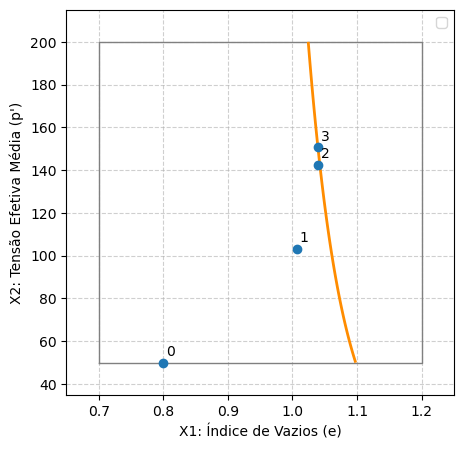

,k,y_k,B,g(x),grad_g(y),||grad_g(y)||,g(y),x_k
0,0,"[-0.461, -1.689, 0.102]",1.753,0.487,"[-0.376, -0.159, -0.198]",0.454,0.487,"[0.8, 50.0, 0.97]"
1,1,"[0.265, -0.505, 0.063]",0.573,0.100,"[-0.274, -0.116, -0.196]",0.356,0.100,"[1.007, 103.316, 0.962]"
2,2,"[0.296, 0.02, 0.193]",0.354,0.006,"[-0.257, -0.108, -0.202]",0.344,0.006,"[1.04, 142.565, 0.988]"
3,3,"[0.268, 0.113, 0.211]",0.359,0.000,"[-0.256, -0.108, -0.202]",0.344,-0.000,"[1.04, 150.686, 0.992]"


In [24]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Equação do estado limite g(X)
e, p, n = sp.symbols('e p n')
vetor_simbolico_x = [e, p, n]
g_sym_function = ((1.41 / 1.31) * sp.exp(-1.29 * (e - (1.242 - (0.053 * sp.log(p)))))) - n

def g_fun_numerica_g2(x: np.ndarray) -> float:
    return ((1.41 / 1.31) * np.exp(-1.29 * (x[0] - (1.242 - (0.053 * np.log(x[1])))))) - x[2]

# Transformação X -> Y da equação de estado-limite g(X)
Y1,Y2, Y3 = sp.symbols('Y1 Y2 Y3')
vetor_simbolico_y = [Y1, Y2, Y3]
def g_y_simbolico_fun (vetor_x_simbolico):
    return  ((1.41 / 1.31) * sp.exp(-1.29 * (vetor_x_simbolico[0] - (1.242 - (0.053 * sp.log(vetor_x_simbolico[1])))))) - vetor_x_simbolico[2]  

# Descrição das variáveis aleatórias 

e = variavel_aleatoria(distribuicao='normal', nome='Indices_vazio', simbolo='e')
e.conjunto_parametros(0.98, 0.2) 

p = variavel_aleatoria(distribuicao='lognormal', nome='Mean_effective_stess', simbolo='p')
p.calculo_parametros(167.88, 109.04) 

n = variavel_aleatoria(distribuicao='lognormal', nome='N', simbolo='N')
n.calculo_parametros(0.97, 0.2) 

vetor_va = [e, p, n]

# Montagem das matrizes de observações e correlações
matriz_dummy_obs = np.zeros((3, 3)) # Matriz das observações para iniciar o algoritmo

Rx_entrada = np.array([
    [1.0, -0.23, 0.0],
    [-0.23, 1.0, 0.0],
    [0.0, 0.0, 1.0],
])

# 4. Inicializar VX (T3)
vx_obj = vetores_variavel_aleatoria(matriz_dummy_obs, vetor_va)
vx_obj.matriz_correlacao_x = Rx_entrada
Rz = vx_obj.matriz_correlacao_nataf() # Garante que Cz é calculado (Cz = Rx = I)
J_yz, J_zy = vx_obj.decomposicao_cholesky()

# Ponto inicial (ponto médio)
x_start = np.array([0.8, 50.0, 0.97])
ponto_projeto_obj = Ponto_projeto_HRLF(vx_obj, g_fun_numerica_g2, vetor_simbolico_y, g_y_simbolico_fun, g_sym_function, vetor_simbolico_x, x_start, max_iter=200)

# Resultado da iteração
resultado_iteração_g2 = ponto_projeto_obj.execution()
dados_arredondados = [[np.round(x, 3) for x in linha] for linha in resultado_iteração_g2]

# Montagem da tabela
tabela_g2 = pd.DataFrame(dados_arredondados, columns=['k', 'y_k', 'B', 'g(x)', 'grad_g(y)', '||grad_g(y)||', 'g(y)', 'x_k' ])

# Vetor com os valores de das variáveis
coluna_vetor_x = tabela_g2['x_k'] 

# Separação de X1 e X2
X1_coords = coluna_vetor_x.apply(lambda vec: vec[0]) # X1: e
X2_coords = coluna_vetor_x.apply(lambda vec: vec[1]) # X2: p'

# --- 1. CONFIGURAÇÃO DA VARIÁVEL FIXA (X3 = n) ---
# X3 é fixado em seu valor médio (mu) para fins de plotagem do contorno.
X3_REF = 0.992 # Pega a média de 'n' (0.97)

# Dominio a ser aplicado à g(X)
X1_min = 0.7
X1_max = 1.20 
X2_min = 50.0
X2_max = 200.0 

# Cria uma grade (mesh) de 100x100 pontos para X1 e X2
num_points = 100
X1_grid = np.linspace(X1_min, X1_max, num_points)
X2_grid = np.linspace(X2_min, X2_max, num_points)
X_mesh_1, X_mesh_2 = np.meshgrid(X1_grid, X2_grid)

# Calculo de g(X)
G2_values = np.zeros(X_mesh_1.shape)
for i in range(num_points):
    for j in range(num_points):
        # CORREÇÃO CRÍTICA: Cria um vetor 3D, fixando X3 (n) na sua média
        x_point = np.array([X_mesh_1[i, j], X_mesh_2[i, j], X3_REF]) 
        G2_values[i, j] = g_fun_numerica_g2(x_point)

# --- INÍCIO DA PLOTAGEM ---
plt.figure(figsize=(5, 5))

# Contorno dos valores possíveis (caixa de domínio)
plt.plot([X1_min, X1_max, X1_max, X1_min, X1_min], 
         [X2_min, X2_min, X2_max, X2_max, X2_min], 
         color='gray', linestyle='-', linewidth=1)

# Plot de g(X)=0
CS = plt.contour(X_mesh_1, X_mesh_2, G2_values, levels=[0], colors='darkorange', linestyles='-', linewidths=2)
#CS.collections[0].set_label(f'g(e, p\', n={X3_REF:.2f})=0 (Linha de Falha)')

# Trajetória de convergência
plt.plot(X1_coords, X2_coords, marker='o',linestyle='', color='tab:blue', label='')

# Ponto de Projeto (x*)
#plt.scatter(X1_coords.iloc[-1], X2_coords.iloc[-1], color='red', marker='o', s=100, label='Ponto de Projeto (x*)')

# Anotações dos pontos
for k, (x1, x2) in enumerate(zip(X1_coords, X2_coords)):
    plt.annotate(str(k), (x1, x2), textcoords="offset points", xytext=(5,5), ha='center')

# Ajusta os limites do eixo para cobrir o domínio e um pouco mais
plt.xlim(X1_min - 0.1*(X1_max-X1_min), X1_max + 0.1*(X1_max-X1_min))
plt.ylim(X2_min - 0.1*(X2_max-X2_min), X2_max + 0.1*(X2_max-X2_min))

plt.xlabel('X1: Índice de Vazios (e)')
plt.ylabel('X2: Tensão Efetiva Média (p\')')
#plt.title('Convergência do FORM no Espaço Físico (g2) com X3 fixo')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

tabela_g2

# Tentativa de limites bi-modais

In [27]:
import numpy as np
import sympy as sp
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt

# Equação do estado limite g1(X)
e,p,n = sp.symbols('e p n')
vetor_simbolico_g1 = [e, p, n]
g_sym_function_g1 = -(e - (1.242 - (0.053 * sp.log(p)))) - 0.05

def g_fun_numerica_g1(x: np.ndarray) -> float:
    return -(x[0] - (1.242 - (0.053 * np.log(x[1])))) - 0.05

# Transformação X -> Y da equação de estado-limite g(X)
Y1,Y2, Y3 = sp.symbols('Y1 Y2 Y3')
vetor_simbolico_y_g1 = [Y1, Y2, Y3]
def g_y_simbolico_fun_g1 (vetor_x_simbolico):
    return  -(vetor_x_simbolico[0] - (1.242 - (0.053 * sp.log(vetor_x_simbolico[1])))) - 0.05     

# Equação do estado limite g2(X)
e, p, n = sp.symbols('e p n')
vetor_simbolico_g2 = [e, p, n]
g_sym_function_g2 = ((1.41 / 1.31) * sp.exp(-1.29 * (e - (1.242 - (0.053 * sp.log(p)))))) - n

def g_fun_numerica_g2(x: np.ndarray) -> float:
    return ((1.41 / 1.31) * np.exp(-1.29 * (x[0] - (1.242 - (0.053 * np.log(x[1])))))) - x[2]

# Transformação X -> Y da equação de estado-limite g(X)
Y1,Y2, Y3 = sp.symbols('Y1 Y2 Y3')
vetor_simbolico_y_g2 = [Y1, Y2, Y3]
def g_y_simbolico_fun_g2 (vetor_x_simbolico):
    return  ((1.41 / 1.31) * sp.exp(-1.29 * (vetor_x_simbolico[0] - (1.242 - (0.053 * sp.log(vetor_x_simbolico[1])))))) - vetor_x_simbolico[2]   

# Descrição das variáveis aleatórias 
e = variavel_aleatoria(distribuicao='normal', nome='Indices_vazio', simbolo='e')
e.conjunto_parametros(0.98, 0.2) 

p = variavel_aleatoria(distribuicao='lognormal', nome='Mean_effective_stess', simbolo='p')
p.calculo_parametros(167.88, 109.04) 

n = variavel_aleatoria(distribuicao='lognormal', nome='Ratio_stress', simbolo='n')
n.calculo_parametros(0.97, 0.2) 

vetor_va = [e, p, n]

# Montagem das matrizes de observações e correlações
matriz_dummy_obs = np.zeros((3, 3)) # Matriz das observações para iniciar o algoritmo

vetor_va_g1 = [e, p, n]
vetor_va_g2 = [e, p, n]

# Considerando apenas a função g1
# Montagem das matrizes de observações e correlações
matriz_dummy_obs = np.zeros((3, 3)) # Matriz das observações para iniciar o algoritmo

Rx_entrada_g1 = np.array([
    [1.0, -0.23, 0.0],
    [-0.23, 1.0, 0.0],
    [0.0, 0.0, 1.0],
])

# 4. Inicializar VX (T3)
vx_obj_g1 = vetores_variavel_aleatoria(matriz_dummy_obs, vetor_va_g1)
vx_obj_g1.matriz_correlacao_x = Rx_entrada_g1
Rz = vx_obj_g1.matriz_correlacao_nataf() # Garante que Cz é calculado (Cz = Rx = I)
J_yz, J_zy = vx_obj_g1.decomposicao_cholesky()

# Ponto inicial (ponto médio)
x_start_g1 = np.array([0.8, 50.0, 0.97])
ponto_projeto_obj = Ponto_projeto_HRLF(vx_obj_g1, g_fun_numerica_g1, vetor_simbolico_g1, g_y_simbolico_fun_g1, g_sym_function_g1, vetor_simbolico_g1, x_start_g1, max_iter=200)

# Resultado da iteração
resultado_iteracao_g1 = ponto_projeto_obj.execution()

dados_arredondados_g1 = [[np.round(x, 3) for x in linha] for linha in resultado_iteracao_g1]
tabela_g1 = pd.DataFrame(dados_arredondados_g1, columns=['k', 'y_k', 'B', 'g(x)', 'grad_g(y)', '||grad_g(y)||', 'g(y)', 'x_k' ])

beta_g1 = resultado_iteracao_g1[2][2]
grad_y_g1 = resultado_iteracao_g1[2][4]

# Considerando apenas a função g2
# Montagem das matrizes de observações e correlações
matriz_dummy_obs = np.zeros((3, 3)) # Matriz das observações para iniciar o algoritmo

Rx_entrada_g2 = np.array([
    [1.0, -0.23, 0.0],
    [-0.23, 1.0, 0.0],
    [0.0, 0.0, 1.0],
])

# 4. Inicializar VX (T3)
vx_obj_g2 = vetores_variavel_aleatoria(matriz_dummy_obs, vetor_va_g2)
vx_obj_g2.matriz_correlacao_x = Rx_entrada_g2
Rz = vx_obj_g2.matriz_correlacao_nataf() # Garante que Cz é calculado (Cz = Rx = I)
J_yz, J_zy = vx_obj_g2.decomposicao_cholesky()

# Ponto inicial (ponto médio)
x_start_g2 = np.array([0.8, 50.0, 0.97])
ponto_projeto_obj = Ponto_projeto_HRLF(vx_obj_g2, g_fun_numerica_g2, vetor_simbolico_g2, g_y_simbolico_fun_g2, g_sym_function_g2, vetor_simbolico_g2, x_start_g2, max_iter=200)

# Resultado da iteração
resultado_iteracao_g2 = ponto_projeto_obj.execution()
dados_arredondados_g2 = [[np.round(x, 3) for x in linha] for linha in resultado_iteracao_g2]
tabela_g2 = pd.DataFrame(dados_arredondados_g2, columns=['k', 'y_k', 'B', 'g(x)', 'grad_g(y)', '||grad_g(y)||', 'g(y)', 'x_k' ])

beta_g2 = resultado_iteracao_g2[3][2]
grad_y_g2 = resultado_iteracao_g2[3][4]

# Correlação
corr_g2_g1 = (grad_y_g2.T / np.linalg.norm(grad_y_g2)) @ (grad_y_g1 / np.linalg.norm(grad_y_g1))

# Interseção entre g1 e g2

# Probabilidade do evento Aij
CDF_beta_g1 = st.norm.cdf(-beta_g1)
Y_A_ij = (beta_g2 - (corr_g2_g1 * beta_g1)) / (np.sqrt(1 - (corr_g2_g1**2)))
P_A_ij = CDF_beta_g1 * st.norm.cdf(-Y_A_ij)

# Probabilidade do evento Bij
CDF_beta_g2 = st.norm.cdf(-beta_g2)
Y_B_ij = (beta_g1 - (corr_g2_g1 * beta_g2)) / (np.sqrt(1 - (corr_g2_g1**2)))
P_B_ij = CDF_beta_g2 * st.norm.cdf(-Y_B_ij)

if corr_g2_g1 >= 0:
    P_g1_inter_g2_inf = P_A_ij + P_B_ij
    P_g1_inter_g2_sup = np.maximum(P_A_ij, P_B_ij)
else:
    P_g1_inter_g2_inf = np.minimum(P_A_ij, P_B_ij)
    P_g1_inter_g2_sup = 0

# Limite inferior da probbilidade de falha do sistema
CDF_beta_g1 = st.norm.cdf(-beta_g1)
CDF_beta_g2 = st.norm.cdf(-beta_g2)

pf_sis_inf = CDF_beta_g1 + CDF_beta_g2 - P_g1_inter_g2_inf

#Limite superior da probbilidade de falha do sistema
pf_sis_sup = CDF_beta_g1 + CDF_beta_g2 - P_g1_inter_g2_sup 

print("Utilizando os limites bi-modais:")
print(f"Temos que o limite inferiror é {pf_sis_inf}")
print(f"Temos que o limite superior é {pf_sis_sup}")

# Limites unimodais
pf_sis_uni_inf = np.maximum(CDF_beta_g1, CDF_beta_g2)
pf_sis_uni_sup = CDF_beta_g1 + CDF_beta_g2

#print("Utilizando os limites uni-modais:")
#print(f"Temos que o limite inferiror é {pf_sis_uni_inf}")
#print(f"Temos que o limite superior é {pf_sis_uni_sup}")
#print(tabela_g1)
#print(tabela_g2)
print(P_g1_inter_g2_inf, P_g1_inter_g2_sup)

Utilizando os limites bi-modais:
Temos que o limite inferiror é 0.41675931543073763
Temos que o limite superior é 0.5739387683164086
0.3514252737093114 0.19424582082364047


# Tentativa utilizando as duas Equações e Monte-Carlo

In [49]:
import numpy as np
import scipy.stats as st
from scipy.stats import norm
from typing import List, Tuple, Callable

# --- VARIÁVEIS DO SISTEMA ---
N_VARS = 3 # e, p, n

# Valores para teste (Substitua pelos resultados do seu FORM)
MU_X = np.array([0.98, 167.88, 0.97]) # e, p, n
SIGMA_X = np.array([0.2, 109.04, 0.2])

# --- RESULTADOS DO FORM ---
J_yz_FORM = J_yz
J_zy_FORM = J_zy

# Indices de Confiabilidade
#Função g1
a = resultado_iteracao_g1
BETA_G1 = a[2][2]
ponto_projeto_g1 = a[2][7] #Espaço X

#Função g2
b = resultado_iteracao_g2
BETA_G2 = b[3][2]
ponto_projeto_g2 = b[3][7] #Espaço X

# Matriz de Correlação no espaço Z (Cz = I para Normais Independentes)
CZ_MATRIX = np.eye(N_VARS) 

# PONTOS DE PROJETO NO ESPAÇO Y (y* = -alpha * beta)
# Simplificação: Usaremos alpha = [0, 0, 0, 1] e a beta (y* = [0, 0, 0, -3.637])
# Em produção, você usaria o vetor y* completo do seu FORM.
Y_G1_STAR_OTIMIZADO = a[2][1] # Assumindo alpha similar a [0, 0, 0, -1]
Y_G2_STAR_OTIMIZADO = b[3][1]

# Lista de Pontos de Projeto e Betas
PONTOS_PROJETO_OTIMIZADOS = [Y_G1_STAR_OTIMIZADO, Y_G2_STAR_OTIMIZADO]
BETAS = [BETA_G1, BETA_G2]
MODOS = ['G1', 'G2']

# --- PARÂMETROS PARA TRANSFORMAÇÃO MARGINAL (X -> Z) ---
# X1 (e) é Normal. X2 (p), X3 (n) são Log-Normal.
zeta = np.sqrt(np.log(1 + (SIGMA_X[1:] / MU_X[1:])**2))
lamda = np.log(MU_X[1:]) - 0.5 * zeta**2

MU_Z = np.array([MU_X[0], lamda[0], lamda[1]]) 
SIGMA_Z = np.array([SIGMA_X[0], zeta[0], zeta[1]])


# --- FUNÇÕES AUXILIARES DE PDF (Necessárias para o Ponderamento) ---

def pdf_multivariada_normal_padrao(y_vetor: np.ndarray, media: np.ndarray) -> float:
    """Calcula a PDF multivariada N(media, I) para o Fator de Ponderação."""
    # Assume independência (matriz de cov I).
    pdf_componentes = st.norm.pdf(y_vetor, loc=media, scale=1.0)
    return np.prod(pdf_componentes)

# --- FUNÇÕES DE ESTADO LIMITE (Devem estar implementadas) ---

def g_fun_numerica_g1(x: np.ndarray) -> float:
    return -(x[0] - (1.242 - (0.053 * np.log(x[1])))) - 0.05

def g_fun_numerica_g2(x: np.ndarray) -> float:
    return ((1.41 / 1.31) * np.exp(-1.29 * (x[0] - (1.242 - (0.053 * np.log(x[1])))))) - x[2]

# --- 2. CÁLCULO DOS PESOS DE AMOSTRAGEM (p_j) ---

def calcular_pesos_pj(betas: List[float]) -> np.ndarray:
    """Calcula os pesos p_j para amostragem multi-modal (Eq. 5.31)."""
    phi_neg_beta = np.array([st.norm.cdf(-b) for b in betas])
    soma_prob = np.sum(phi_neg_beta)
    
    # pj = Phi(-beta_j) / Soma(Phi(-beta_k))
    return phi_neg_beta / soma_prob

# ------------------------------------------------------------------------
# 3. ALGORITMO PRINCIPAL DE SIMULAÇÃO (Implementa os Passos 1 a 5)
# ------------------------------------------------------------------------
def estender_y_star(y_star_otimizado: np.ndarray, modo_indice: int) -> np.ndarray:
    """Estende o ponto de projeto 3D (FORM) para o vetor 4D do sistema."""
    N_VARS = 3
    y_star_sistema = np.zeros(N_VARS)
    
    # Modo G1 (Índice 0): e, p. 
    if modo_indice == 0:
        # Posições do vetor 3D
        y_star_sistema[0] = y_star_otimizado[0] # S
        y_star_sistema[1] = y_star_otimizado[1] # H
        
    # Modo G2 (Índices 1, 2): e, p, n. 
    else: 
        y_star_sistema = y_star_otimizado.copy() # E
       
    return y_star_sistema

def transformacao_nataf_inversa(Z_correlacionado: np.ndarray, mu_z: np.ndarray, sigma_z: np.ndarray) -> np.ndarray:
    """Aplica a transformação inversa marginal X = F-1(Phi(Z)) para distribuições mistas."""
    X_sample = np.zeros_like(Z_correlacionado)
    
    # Z_correlacionado já é o vetor Z no espaço Normal (correlacionado)
    
    # 1. Variável X1 (e): Normal. Z1 está correlacionado, mas X1 é Normal. X = mu + sigma*Z
    X_sample[0] = mu_z[0] + sigma_z[0] * Z_correlacionado[0]
    
    # 2. Variável X2 (p): Log-Normal. X = exp(lambda + zeta*Z)
    X_sample[1] = np.exp(mu_z[1] + sigma_z[1] * Z_correlacionado[1])
    
    # 3. Variável X3 (n): Log-Normal. X = exp(lambda + zeta*Z)
    X_sample[2] = np.exp(mu_z[2] + sigma_z[2] * Z_correlacionado[2])
    
    return X_sample

def executar_simulacao_is_multimodal_nataf(N_samples: int, mu_x: np.ndarray, sigma_x: np.ndarray, pontos_otimizados: List[np.ndarray], betas: List[float], J_yz_matrix: np.ndarray, random_seed: int = 20000511):
    np.random.seed(random_seed)
    
    N_DIM_VARS = len(MU_X) # 3 (S, E, H, V)
    N_MODOS = len(pontos_otimizados) # 2 (R1, E1, E2)
    
    # 1. Preparação
    pesos_pj = calcular_pesos_pj(betas)
    pf_componentes = [] # Para armazenar I[Xk] * wk
    
    # Variáveis Nataf necessárias para a transformação marginal:
    global MU_Z, SIGMA_Z

    # 2. Geração da Matriz de Amostras Z Brutas (em massa, usando numpy/scipy)
    # Usaremos Normais Padrão do numpy para eficiência
    Z_bruta_indep = np.random.normal(loc=0.0, scale=1.0, size=(N_samples, N_DIM_VARS))

    # 3. LOOP DE AMOSTRAGEM (Passo 1: Geração, Passos 2-5: Avaliação)
    for k in range(N_samples):
        
        # a) Escolha do Modo (Baseado nos pesos p_j)
        modo_indice = np.random.choice(range(N_MODOS), p=pesos_pj)
        y_star_otimizado = pontos_otimizados[modo_indice]

        # 1. Inicializa o vetor 4D com zeros (o valor padrão para componentes independentes)
        y_star_j = estender_y_star(y_star_otimizado, modo_indice)

        # b) Geração da Amostra Yk (Espaço Independente DESLOCADO)
        Z_indep_bruta = Z_bruta_indep[k, :] 
        Y_k_sample = Z_indep_bruta + y_star_j 

        # c) Transformação Nataf Inversa (Y -> Z -> X)
        
        # C.1. Z_indep (Remoção do Deslocamento: Z_k = Y_k - y_star_j)
        # Atenção: Este vetor já é Z_indep_bruta, mas usaremos Y_k_sample - y_star_j para generalizar.
        Z_indep = Y_k_sample - y_star_j 

        # C.2. Z_correlacionado (Imposição da Correlação: Z = J_yz * Z_indep)
        # J_yz é a matriz Lz (decomposição de Cholesky de Rz)
        Z_correlacionado = J_yz_matrix @ Z_indep 
        
        # C.3. Transformação Marginal Z -> X
        X_k_sample = transformacao_nataf_inversa(Z_correlacionado, MU_Z, SIGMA_Z)

        # d) Avaliação da Falha (Passo 2)
        g1 = g_fun_numerica_g1(X_k_sample)
        g2 = g_fun_numerica_g2(X_k_sample)
        g_sistema = max(g1, g2)
        I_k = 1.0 if g_sistema <= 0 else 0.0
        
        # e) Cálculo do Fator de Ponderação (w_k) - Passo 3
        
        # f_Y (PDF Original, centrada em 0)
        f_Y_k = pdf_multivariada_normal_padrao(Z_indep, media=np.zeros(N_DIM_VARS))
        
        # h_Y (PDF Amostragem Multi-modal) = Sum(pj * phi(Yk - yj*))
        h_Y_k = 0.0
        for j in range(N_MODOS): # j = 0, 1
            
            y_star_otimizado_j = pontos_otimizados[j]
            
            # CORREÇÃO CRÍTICA: Estende a média y* de 3D para 4D
            y_j_star_3D = estender_y_star(y_star_otimizado_j, j)
            
            # Agora a PDF usa a média 4D
            pdf_j = pdf_multivariada_normal_padrao(Y_k_sample, media=y_j_star_3D)
            
            h_Y_k += pesos_pj[j] * pdf_j
            
        w_k = f_Y_k / h_Y_k if h_Y_k > 0 else 0.0
        
        # f) Acumulação (Passo 4)
        Pf_contribuicao = w_k * I_k
        pf_componentes.append(Pf_contribuicao)

    # 4. Resultado Final (Passo 4 e 5)
    
    # Pf Estimada (Média)
    Pf_estimate = np.mean(pf_componentes)
    
    # Variância da Estimativa (Passo 5)
    variance_pf = np.var(pf_componentes, ddof=1) / N_samples
    
    return Pf_estimate, variance_pf

# --- EXEMPLO DE USO (Integração com o seu sistema) ---

#N_TESTE = 10000
#Pf_final, Var_Pf = executar_simulacao_is_multimodal(N_TESTE, MU_X, SIGMA_X, PONTOS_PROJETO, BETAS)
#print(f"Pf Estimada: {Pf_final:.4e} | C.V. do Pf: {np.sqrt(Var_Pf) / Pf_final * 100:.2f}%")

#--- EXEMPLO DE USO ---
#Nota: Você deve passar o J_yz (matriz Lz) que você calculou no seu FORM!

Pf_final, Var_Pf = executar_simulacao_is_multimodal_nataf(
     N_samples=10000, 
     mu_x=MU_X, 
     sigma_x=SIGMA_X, 
     pontos_otimizados=PONTOS_PROJETO_OTIMIZADOS, 
     betas=BETAS, 
     J_yz_matrix=J_yz_FORM, # SUA MATRIZ DE CHOLSKY
     random_seed=20000511
 )
print(f"Pf Estimada: {Pf_final:.4e} | C.V. do Pf: {np.sqrt(Var_Pf) / Pf_final * 100:.2f}%")

# 1. Defina o Nível de Confiança
nivel_confianca = 0.95
z_alpha_2 = norm.ppf(1 - (1 - nivel_confianca) / 2) # Retorna 1.960 para 95%

# 2. Calcule o Desvio Padrão da Estimativa
sigma_pf = np.sqrt(Var_Pf)

# 3. Calcule o Intervalo
limite_inferior = Pf_final - z_alpha_2 * sigma_pf
limite_superior = Pf_final + z_alpha_2 * sigma_pf

# O Intervalo de Confiança é [limite_inferior, limite_superior]
print(limite_inferior, limite_superior)

#st.norm.cdf(-beta_g1)
st.norm.cdf(-beta_g2)
Var_Pf

Pf Estimada: 3.5243e-01 | C.V. do Pf: 1.52%
0.3419428378215949 0.36291436551748774


np.float64(2.862226268900426e-05)

# Plot das funções juntas

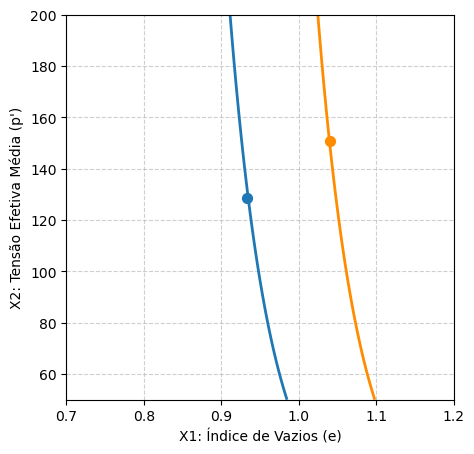

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Valores para o domínio da plotagem (Ajuste conforme seus dados)
X1_min = 0.7
X1_max = 1.20 
X2_min = 50.0
X2_max = 200.0 
num_points = 100


# Valor de X3 (n) fixado na sua média para plotagem (μ_n)
# Assumindo que vx_obj.vetor_va[2] é a variável 'n'.
X3_REF1 = 0.95 
X3_REF2 = 0.992

# --- Geração da Grade ---
X1_grid = np.linspace(X1_min, X1_max, num_points)
X2_grid = np.linspace(X2_min, X2_max, num_points)
X_mesh_1, X_mesh_2 = np.meshgrid(X1_grid, X2_grid)

# --- FUNÇÕES PARA CÁLCULO DOS CONTORNOS ---

def calcular_g_values(g_func, X_mesh_1, X_mesh_2, X3_ref):
    """Calcula os valores g(X) na grade 2D, fixando X3."""
    G_values = np.zeros(X_mesh_1.shape)
    for i in range(X_mesh_1.shape[0]):
        for j in range(X_mesh_1.shape[1]):
            # Cria o vetor 3D: [X1, X2, X3_REF]
            x_point = np.array([X_mesh_1[i, j], X_mesh_2[i, j], X3_ref]) 
            G_values[i, j] = g_func(x_point)
    return G_values

# 1. Calcular Contorno para g1
G1_values = calcular_g_values(g_fun_numerica_g1, X_mesh_1, X_mesh_2, X3_REF1)

# 2. Calcular Contorno para g2
G2_values = calcular_g_values(g_fun_numerica_g2, X_mesh_1, X_mesh_2, X3_REF2)

# --- EXTRAÇÃO DOS PONTOS DE CONVERGÊNCIA (Tabela) ---
X1_coords_g1 = tabela_g1['x_k'].apply(lambda vec: vec[0])
X2_coords_g1 = tabela_g1['x_k'].apply(lambda vec: vec[1])
X1_coords_g2 = tabela_g2['x_k'].apply(lambda vec: vec[0])
X2_coords_g2 = tabela_g2['x_k'].apply(lambda vec: vec[1])

# --- INÍCIO DA PLOTAGEM ---
plt.figure(figsize=(5, 5))

# 1. PLOTAGEM DA LINHA DE FALHA (g1=0)
CS1 = plt.contour(X_mesh_1, X_mesh_2, G1_values, levels=[0], colors='tab:blue', linestyles='-', linewidths=2)
#CS1.collections[0].set_label('$g_1=0$ (Falha de $X_1, X_2$ - X3 fixo)')

# 2. PLOTAGEM DA LINHA DE FALHA (g2=0)
CS2 = plt.contour(X_mesh_1, X_mesh_2, G2_values, levels=[0], colors='darkorange', linestyles='-', linewidths=2)
#CS2.collections[0].set_label('$g_2=0$ (Falha de $X_1, X_2, X_3$ - X3 fixo)')

# 3. CONVERGÊNCIA E PONTOS DE PROJETO

# Trajetória g1
#plt.plot(X1_coords_g1, X2_coords_g1, marker='o', linestyle='', color='tab:blue', alpha=0.5, label='')
# Ponto de Projeto g1 (x*1)
plt.scatter(X1_coords_g1.iloc[-1], X2_coords_g1.iloc[-1], color='tab:blue', marker='o', s=50, label='')

# Trajetória g2
#plt.plot(X1_coords_g2, X2_coords_g2, marker='^', linestyle='', color='darkorange', alpha=0.5, label='')
# Ponto de Projeto g2 (x*2)
plt.scatter(X1_coords_g2.iloc[-1], X2_coords_g2.iloc[-1], color='darkorange', marker='o', s=50, label='')


# --- CONFIGURAÇÃO FINAL ---
#plt.title(f'Linhas de Falha e Pontos de Projeto no Espaço Físico ($X_3=n$ fixo em {X3_REF:.3f})')
plt.xlabel('X1: Índice de Vazios (e)')
plt.ylabel('X2: Tensão Efetiva Média (p\')')
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend(loc='lower right')
plt.show()
